Credits for our MCNN baseline model: https://www.kaggle.com/code/wptouxx/shtech-mcnn

In [3]:
import warnings
warnings.filterwarnings("ignore")
!pip install opendatasets --upgrade --quiet
import opendatasets as od
od.version()

'0.1.22'

In [4]:
dataset_url = 'https://www.kaggle.com/datasets/tthien/shanghaitech'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nksrivastava
Your Kaggle Key: ··········


100%|██████████| 333M/333M [00:02<00:00, 131MB/s]


In [5]:
!pip install torch-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 9.2 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np

In [8]:
import scipy
import scipy.io
import cv2

from matplotlib import pyplot as plt

from scipy.ndimage import gaussian_filter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from PIL import Image

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning import seed_everything

import os

In [9]:
def show(im):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

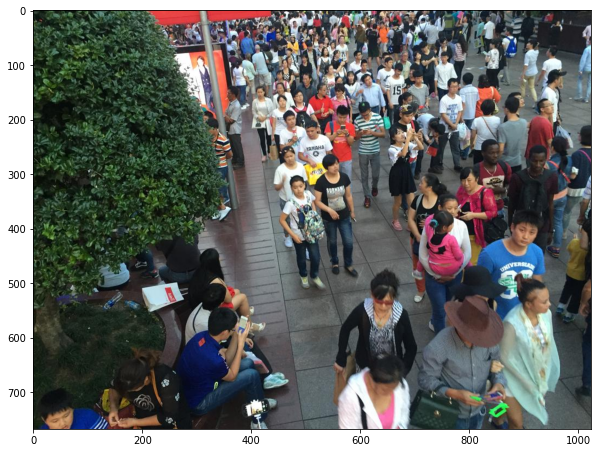

In [10]:
im = cv2.imread('/content/shanghaitech/ShanghaiTech/part_B/train_data/images/IMG_1.jpg', cv2.IMREAD_COLOR)
show(im)

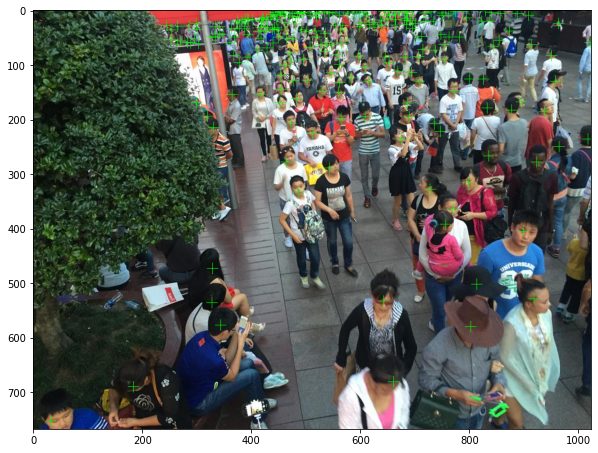

In [11]:
m = scipy.io.loadmat('/content/shanghaitech/ShanghaiTech/part_B/train_data/ground-truth/GT_IMG_1.mat')
ps = m['image_info'][0][0][0][0][0]

for x, y in ps:
    x = int(x)
    y = int(y)
    cv2.drawMarker(im, (x, y), (0, 255, 0))
    
show(im)

In [12]:
from sklearn.model_selection import train_test_split

train = [p.path for p in os.scandir('/content/shanghaitech/ShanghaiTech/part_B/train_data/images/')]
valid_full = [p.path for p in os.scandir('/content/shanghaitech/ShanghaiTech/part_B/test_data/images/')]

## use a small subset for validation
_, valid = train_test_split(valid_full, test_size=64, random_state=42)

len(train), len(valid)

(400, 64)

In [13]:
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [14]:
im_size = 512
aug_train = A.Compose([
    A.RandomCrop(im_size, im_size),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(),
    A.Normalize((0.5), (0.5)),
], keypoint_params=A.KeypointParams(format='xy', angle_in_degrees=False))

aug_val = A.Compose([
    A.Resize(768, 1024),
    A.Normalize((0.5), (0.5)),
], keypoint_params=A.KeypointParams(format='xy', angle_in_degrees=False))

class MyDataset(Dataset):
    def __init__(self, files, aug):
        self.files = files
        self.aug = aug
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fn = self.files[idx]
        
        im = cv2.imread(fn, cv2.IMREAD_COLOR)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        
        m = scipy.io.loadmat(fn.replace('images', 'ground-truth').replace('IMG', 'GT_IMG').replace('.jpg', '.mat'))
        ps = m['image_info'][0][0][0][0][0]
        
        rst = self.aug(image=im, keypoints=ps)
        im = rst['image']
        ps = rst['keypoints']
        
        dm = np.zeros((im.shape[0], im.shape[1]), dtype=np.float32)
        for x, y in ps:
            x = int(x)
            y = int(y)
            dm[y, x] = 1

        sigma = 4
        dm = gaussian_filter(dm, sigma=sigma, truncate=4*sigma)
        
        dm = cv2.resize(dm, (im.shape[1] // 4, im.shape[0] // 4), interpolation=cv2.INTER_LINEAR)
        dm *= 16
        
        im = torch.from_numpy(im)
        dm = torch.from_numpy(dm)
        
        return im, dm

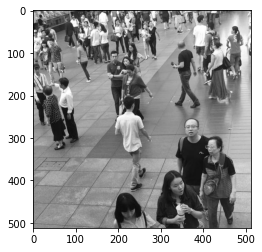

In [15]:
ds = MyDataset(train, aug_train)
im, dm = ds[0]
plt.imshow(im, cmap='gray')

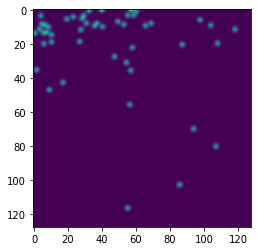

In [16]:
plt.imshow(dm)

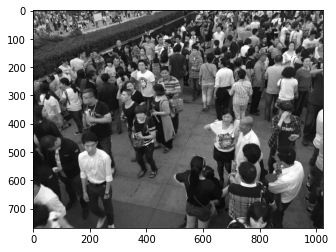

In [17]:
ds = MyDataset(valid, aug_val)
im, dm = ds[0]
plt.imshow(im, cmap='gray')

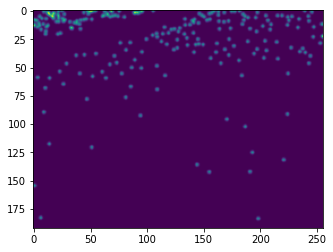

In [18]:
plt.imshow(dm)

In [19]:
dm.sum()

tensor(230.)

In [20]:
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, relu=True, same_padding=False, bn=False):
        super(Conv2d, self).__init__()
        padding = int((kernel_size - 1) / 2) if same_padding else 0
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else None
        self.relu = nn.ReLU(inplace=True) if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

In [21]:
class MCNN(LightningModule):
    '''
    Multi-column CNN 
        -Implementation of Single Image Crowd Counting via Multi-column CNN (Zhang et al.)
    '''
    
    def __init__(self, lr, batch_size, max_steps, bn=False):
        super(MCNN, self).__init__()
        
        self.lr = lr
        self.save_hyperparameters()
        
        self.use = 0
        
        self.branch1 = nn.Sequential(Conv2d( 1, 16, 9, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(16, 32, 7, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(32, 16, 7, same_padding=True, bn=bn),
                                     Conv2d(16,  8, 7, same_padding=True, bn=bn))
        
        self.branch2 = nn.Sequential(Conv2d( 1, 20, 7, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(20, 40, 5, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(40, 20, 5, same_padding=True, bn=bn),
                                     Conv2d(20, 10, 5, same_padding=True, bn=bn))
        
        self.branch3 = nn.Sequential(Conv2d( 1, 24, 5, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(24, 48, 3, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(48, 24, 3, same_padding=True, bn=bn),
                                     Conv2d(24, 12, 3, same_padding=True, bn=bn))
        
        self.fuse = nn.Sequential(Conv2d( 30, 1, 1, same_padding=True, bn=bn))
        
        self.out1 = nn.Sequential(Conv2d( 8, 1, 1, same_padding=True, bn=bn))
        self.out2 = nn.Sequential(Conv2d( 10, 1, 1, same_padding=True, bn=bn))
        self.out3 = nn.Sequential(Conv2d( 12, 1, 1, same_padding=True, bn=bn))
        
        self.crit = nn.MSELoss()
        
    def forward(self, im_data):
        im_data = im_data.unsqueeze(1)
        x1 = self.branch1(im_data)
        x2 = self.branch2(im_data)
        x3 = self.branch3(im_data)
        
        
        if self.use == 0:
            x = torch.cat((x1,x2,x3),1)
            x = self.fuse(x)
        elif self.use == 1:
            x = self.out1(x1)
        elif self.use == 2:
            x = self.out2(x2)
        elif self.use == 3:
            x = self.out3(x3)
        
        return x.squeeze(1)
    
    
    def training_step(self, batch, batch_idx):
        self.train()
        x, y = batch
        
        pred = self(x)
        loss = self.crit(pred, y)
        
        pred_sum = torch.round(pred.sum(dim=(1,2))).int()
        gt_sum = torch.round(y.sum(dim=(1,2))).int()
        acc = (pred_sum == gt_sum).float().mean()
        
        mae = torch.abs(pred_sum - gt_sum).float().mean()
        
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        self.log('train_mae', mae)
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            self.eval()
            x, y = batch
            
            pred = self(x)
            loss = self.crit(pred, y)
        
            pred_sum = torch.round(pred.sum(dim=(1,2))).int()
            gt_sum = torch.round(y.sum(dim=(1,2))).int()
            acc = (pred_sum == gt_sum).float().mean()

            mae = torch.abs(pred_sum - gt_sum).float().mean()
            
            self.log('val_loss', loss)
            self.log('val_acc', acc)
            self.log('val_mae', mae)
            
            
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=1e-4)
        
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.lr, total_steps=self.hparams.max_steps, pct_start=0.1, cycle_momentum=False),
            'interval': 'step',
            'frequency': 1
        }
        
        return [optimizer], [scheduler]

In [22]:
def weights_normal_init(model, dev=0.01):
    if isinstance(model, list):
        for m in model:
            weights_normal_init(m, dev)
    else:
        for n, m in model.named_modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, dev)
                if m.bias is not None:
                    m.bias.data.fill_(0.0)
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0.0, dev)

In [23]:
batch_size = 32
epochs = 300
max_steps = epochs * len(train) // batch_size

In [24]:
train_loader = DataLoader(MyDataset(train, aug_train), batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(MyDataset(valid, aug_val), batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)

In [31]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
seed_everything(42)

checkpoint_cb = ModelCheckpoint(
    save_top_k=1,
    save_last=True,
    verbose=True,
    monitor='val_mae',
    mode='min'
)

trainer = Trainer(max_steps=max_steps, precision=16, benchmark=True, callbacks=[checkpoint_cb, LearningRateMonitor()])

lr = 3e-4

model = MCNN(lr, batch_size, max_steps)
weights_normal_init(model, dev=0.01)

model.use = 0

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | branch1 | Sequential | 57.8 K
1 | branch2 | Sequential | 46.1 K
2 | branch3 | Sequential | 24.0 K
3 | fuse    | Sequential | 31    
4 | out1    | Sequential | 9     
5 | out2    | Sequential | 11    
6 | out3    | Sequential | 13    
7 | crit    | MSELoss    | 0     
---------------------------------------
127 K     Tra

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 12: 'val_mae' reached 115.90625 (best 115.90625), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=0-step=12.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 24: 'val_mae' reached 107.15625 (best 107.15625), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=1-step=24.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 36: 'val_mae' reached 96.01562 (best 96.01562), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=2-step=36.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 48: 'val_mae' reached 84.81250 (best 84.81250), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=3-step=48.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 60: 'val_mae' reached 74.00000 (best 74.00000), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=4-step=60.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 72: 'val_mae' reached 68.54688 (best 68.54688), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=5-step=72.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 84: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 96: 'val_mae' reached 68.18750 (best 68.18750), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=7-step=96.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 108: 'val_mae' reached 68.14062 (best 68.14062), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=8-step=108.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 120: 'val_mae' reached 66.29688 (best 66.29688), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=9-step=120.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 132: 'val_mae' reached 65.90625 (best 65.90625), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=10-step=132.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 144: 'val_mae' reached 58.68750 (best 58.68750), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=11-step=144.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 156: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 168: 'val_mae' reached 57.10938 (best 57.10938), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=13-step=168.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 180: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 192: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 204: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 216: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 228: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 240: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 252: 'val_mae' reached 56.76562 (best 56.76562), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=20-step=252.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 264: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 276: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 288: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 300: 'val_mae' reached 56.75000 (best 56.75000), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=24-step=300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 312: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 324: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 336: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 348: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 360: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 372: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 384: 'val_mae' reached 55.65625 (best 55.65625), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=31-step=384.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 396: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 408: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 420: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 432: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 444: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 456: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 468: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 480: 'val_mae' reached 54.50000 (best 54.50000), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=39-step=480.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 492: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 504: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 42, global step 516: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 43, global step 528: 'val_mae' reached 53.89062 (best 53.89062), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=43-step=528.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 44, global step 540: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 45, global step 552: 'val_mae' reached 53.81250 (best 53.81250), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=45-step=552.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 46, global step 564: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 47, global step 576: 'val_mae' reached 52.70312 (best 52.70312), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=47-step=576.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 48, global step 588: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 600: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 50, global step 612: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 51, global step 624: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 52, global step 636: 'val_mae' reached 52.25000 (best 52.25000), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=52-step=636.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 53, global step 648: 'val_mae' reached 51.50000 (best 51.50000), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=53-step=648.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 54, global step 660: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 55, global step 672: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 56, global step 684: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 57, global step 696: 'val_mae' reached 50.78125 (best 50.78125), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=57-step=696.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 58, global step 708: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 59, global step 720: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 60, global step 732: 'val_mae' reached 48.50000 (best 48.50000), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=60-step=732.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 61, global step 744: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 62, global step 756: 'val_mae' reached 48.48438 (best 48.48438), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=62-step=756.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 63, global step 768: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 64, global step 780: 'val_mae' reached 48.14062 (best 48.14062), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=64-step=780.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 65, global step 792: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 66, global step 804: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 67, global step 816: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 68, global step 828: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 69, global step 840: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 70, global step 852: 'val_mae' reached 47.31250 (best 47.31250), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=70-step=852.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 71, global step 864: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 72, global step 876: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 73, global step 888: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 74, global step 900: 'val_mae' reached 43.01562 (best 43.01562), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=74-step=900.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 75, global step 912: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 76, global step 924: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 77, global step 936: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 78, global step 948: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 79, global step 960: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 80, global step 972: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 81, global step 984: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 82, global step 996: 'val_mae' reached 42.42188 (best 42.42188), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=82-step=996.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 83, global step 1008: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 84, global step 1020: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 85, global step 1032: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 86, global step 1044: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 87, global step 1056: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 88, global step 1068: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 89, global step 1080: 'val_mae' reached 41.28125 (best 41.28125), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=89-step=1080.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 90, global step 1092: 'val_mae' reached 41.26562 (best 41.26562), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=90-step=1092.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 91, global step 1104: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 92, global step 1116: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 93, global step 1128: 'val_mae' reached 40.60938 (best 40.60938), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=93-step=1128.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 94, global step 1140: 'val_mae' reached 38.96875 (best 38.96875), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=94-step=1140.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 95, global step 1152: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 96, global step 1164: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 97, global step 1176: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 98, global step 1188: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 99, global step 1200: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 100, global step 1212: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 101, global step 1224: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 102, global step 1236: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 103, global step 1248: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 104, global step 1260: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 105, global step 1272: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 106, global step 1284: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 107, global step 1296: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 108, global step 1308: 'val_mae' reached 38.81250 (best 38.81250), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=108-step=1308.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 109, global step 1320: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 110, global step 1332: 'val_mae' reached 36.98438 (best 36.98438), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=110-step=1332.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 111, global step 1344: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 112, global step 1356: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 113, global step 1368: 'val_mae' reached 34.85938 (best 34.85938), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=113-step=1368.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 114, global step 1380: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 115, global step 1392: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 116, global step 1404: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 117, global step 1416: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 118, global step 1428: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 119, global step 1440: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 120, global step 1452: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 121, global step 1464: 'val_mae' reached 34.17188 (best 34.17188), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=121-step=1464.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 122, global step 1476: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 123, global step 1488: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 124, global step 1500: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 125, global step 1512: 'val_mae' reached 33.18750 (best 33.18750), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=125-step=1512.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 126, global step 1524: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 127, global step 1536: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 128, global step 1548: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 129, global step 1560: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 130, global step 1572: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 131, global step 1584: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 132, global step 1596: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 133, global step 1608: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 134, global step 1620: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 135, global step 1632: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 136, global step 1644: 'val_mae' reached 31.90625 (best 31.90625), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=136-step=1644.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 137, global step 1656: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 138, global step 1668: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 139, global step 1680: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 140, global step 1692: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 141, global step 1704: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 142, global step 1716: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 143, global step 1728: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 144, global step 1740: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 145, global step 1752: 'val_mae' reached 31.89062 (best 31.89062), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=145-step=1752.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 146, global step 1764: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 147, global step 1776: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 148, global step 1788: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 149, global step 1800: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 150, global step 1812: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 151, global step 1824: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 152, global step 1836: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 153, global step 1848: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 154, global step 1860: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 155, global step 1872: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 156, global step 1884: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 157, global step 1896: 'val_mae' reached 31.01562 (best 31.01562), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=157-step=1896.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 158, global step 1908: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 159, global step 1920: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 160, global step 1932: 'val_mae' reached 30.20312 (best 30.20312), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=160-step=1932.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 161, global step 1944: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 162, global step 1956: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 163, global step 1968: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 164, global step 1980: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 165, global step 1992: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 166, global step 2004: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 167, global step 2016: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 168, global step 2028: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 169, global step 2040: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 170, global step 2052: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 171, global step 2064: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 172, global step 2076: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 173, global step 2088: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 174, global step 2100: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 175, global step 2112: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 176, global step 2124: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 177, global step 2136: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 178, global step 2148: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 179, global step 2160: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 180, global step 2172: 'val_mae' reached 28.48438 (best 28.48438), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=180-step=2172.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 181, global step 2184: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 182, global step 2196: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 183, global step 2208: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 184, global step 2220: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 185, global step 2232: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 186, global step 2244: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 187, global step 2256: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 188, global step 2268: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 189, global step 2280: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 190, global step 2292: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 191, global step 2304: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 192, global step 2316: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 193, global step 2328: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 194, global step 2340: 'val_mae' reached 28.03125 (best 28.03125), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=194-step=2340.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 195, global step 2352: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 196, global step 2364: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 197, global step 2376: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 198, global step 2388: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 199, global step 2400: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 200, global step 2412: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 201, global step 2424: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 202, global step 2436: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 203, global step 2448: 'val_mae' reached 27.17188 (best 27.17188), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=203-step=2448.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 204, global step 2460: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 205, global step 2472: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 206, global step 2484: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 207, global step 2496: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 208, global step 2508: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 209, global step 2520: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 210, global step 2532: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 211, global step 2544: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 212, global step 2556: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 213, global step 2568: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 214, global step 2580: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 215, global step 2592: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 216, global step 2604: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 217, global step 2616: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 218, global step 2628: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 219, global step 2640: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 220, global step 2652: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 221, global step 2664: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 222, global step 2676: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 223, global step 2688: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 224, global step 2700: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 225, global step 2712: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 226, global step 2724: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 227, global step 2736: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 228, global step 2748: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 229, global step 2760: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 230, global step 2772: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 231, global step 2784: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 232, global step 2796: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 233, global step 2808: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 234, global step 2820: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 235, global step 2832: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 236, global step 2844: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 237, global step 2856: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 238, global step 2868: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 239, global step 2880: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 240, global step 2892: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 241, global step 2904: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 242, global step 2916: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 243, global step 2928: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 244, global step 2940: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 245, global step 2952: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 246, global step 2964: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 247, global step 2976: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 248, global step 2988: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 249, global step 3000: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 250, global step 3012: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 251, global step 3024: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 252, global step 3036: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 253, global step 3048: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 254, global step 3060: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 255, global step 3072: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 256, global step 3084: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 257, global step 3096: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 258, global step 3108: 'val_mae' reached 26.25000 (best 26.25000), saving model to '/content/lightning_logs/version_1/checkpoints/epoch=258-step=3108.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 259, global step 3120: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 260, global step 3132: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 261, global step 3144: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 262, global step 3156: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 263, global step 3168: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 264, global step 3180: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 265, global step 3192: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 266, global step 3204: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 267, global step 3216: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 268, global step 3228: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 269, global step 3240: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 270, global step 3252: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 271, global step 3264: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 272, global step 3276: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 273, global step 3288: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 274, global step 3300: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 275, global step 3312: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 276, global step 3324: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 277, global step 3336: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 278, global step 3348: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 279, global step 3360: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 280, global step 3372: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 281, global step 3384: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 282, global step 3396: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 283, global step 3408: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 284, global step 3420: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 285, global step 3432: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 286, global step 3444: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 287, global step 3456: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 288, global step 3468: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 289, global step 3480: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 290, global step 3492: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 291, global step 3504: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 292, global step 3516: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 293, global step 3528: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 294, global step 3540: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 295, global step 3552: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 296, global step 3564: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 297, global step 3576: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 298, global step 3588: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 299, global step 3600: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 300, global step 3612: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 301, global step 3624: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 302, global step 3636: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 303, global step 3648: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 304, global step 3660: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 305, global step 3672: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 306, global step 3684: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 307, global step 3696: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 308, global step 3708: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 309, global step 3720: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 310, global step 3732: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 311, global step 3744: 'val_mae' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 312, global step 3750: 'val_mae' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=3750` reached.


# `Loading model from last checkpoint`

Credits: https://www.kaggle.com/code/wptouxx/shtech-mcnn-eval/notebook

In [47]:
from tqdm.notebook import tqdm

In [48]:
model = MCNN.load_from_checkpoint('/content/lightning_logs/version_1/checkpoints/epoch=258-step=3108.ckpt')
model = model.cuda()
model.eval()
rst = []
gt = []
for x, y in tqdm(val_loader):
    with torch.no_grad():
        x = x.cuda(non_blocking=True)
        pred = torch.round(model(x).sum(dim=(1,2))).int().cpu().numpy()
        
    rst.append(pred)
    gt.append(y.sum(dim=(1,2)).int().numpy())
    
rst = np.concatenate(rst, axis=0)
gt = np.concatenate(gt, axis=0)

  0%|          | 0/2 [00:00<?, ?it/s]

#MAE

In [50]:
print("MAE:", np.abs((rst - gt)).astype(np.float32).mean())

MAE: 26.28125


#MSE

In [51]:
print("MSE:", ((rst - gt) ** 2).mean())

MSE: 1876.84375


Convert lightning_logs to zip file so that it can be downloaded

In [53]:
!zip -r /content/lightning_logs.zip /content/lightning_logs

  adding: content/lightning_logs/ (stored 0%)
  adding: content/lightning_logs/version_1/ (stored 0%)
  adding: content/lightning_logs/version_1/checkpoints/ (stored 0%)
  adding: content/lightning_logs/version_1/checkpoints/last.ckpt (deflated 9%)
  adding: content/lightning_logs/version_1/checkpoints/epoch=258-step=3108.ckpt (deflated 9%)
  adding: content/lightning_logs/version_1/events.out.tfevents.1679210110.5021247af25f.403.1 (deflated 68%)
  adding: content/lightning_logs/version_1/hparams.yaml (stored 0%)
  adding: content/lightning_logs/version_0/ (stored 0%)
  adding: content/lightning_logs/version_0/hparams.yaml (stored 0%)
  adding: content/lightning_logs/version_0/events.out.tfevents.1679209474.5021247af25f.403.0 (deflated 30%)


Download lightning_logs.zip

In [54]:
from google.colab import files
files.download("/content/lightning_logs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
model.eval()

MCNN(
  (branch1): Sequential(
    (0): Conv2d(
      (conv): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (relu): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(
      (conv): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (relu): ReLU(inplace=True)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(
      (conv): Conv2d(32, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (relu): ReLU(inplace=True)
    )
    (5): Conv2d(
      (conv): Conv2d(16, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (relu): ReLU(inplace=True)
    )
  )
  (branch2): Sequential(
    (0): Conv2d(
      (conv): Conv2d(1, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (relu): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Co

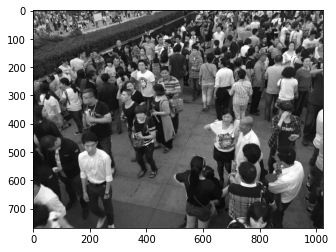

In [55]:
ds = MyDataset(valid, aug_val)
d = ds[0][0]
plt.imshow(d, cmap='gray')

In [ ]:
!pip list